## **1. Mount google drive**
---

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **2. Import the necessary libraries**
---

In [2]:
import matplotlib
import sklearn
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import tensorflow as tf


from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger,LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

print("Versions of key libraries")
print("---")
print("tensorflow: ", tf.__version__)
print("numpy:      ", np.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)

Versions of key libraries
---
tensorflow:  2.5.0
numpy:       1.19.5
matplotlib:  3.2.2
sklearn:     0.22.2.post1


## **3.Create a function to plot image without axis**
---

In [3]:
def implt(img):
    plt.figure()
    plt.imshow(img)
    plt.axis('off')

print(implt)

<function implt at 0x7f515b2b9b00>


## **4. Set matplotlib to have seaborn plot style**
---

In [4]:
plt.style.use('seaborn')                   # if want to use the default style, set 'classic'
plt.rcParams['ytick.right']     = True
plt.rcParams['ytick.labelright']= True
plt.rcParams['ytick.left']      = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams['figure.figsize']  = [7,7]   # Set the figure size to be 7 inch for (width,height)

print("Matplotlib setup completes.")

Matplotlib setup completes.


## **5. Prepare Cifar10 data for training and testing**
---
* Step 1: Load the cifar10 
* Step 2: Check the shape and type of the data
* Step 3: Convert the data into float32 and rescale the values from the range of 0\~255 into 0\~1
* Step 4: Retrieve the row size and the column size of each image
* Step 5: Perform one-hot enconding on the labels
* Step 6: Retrieve the number of classes in this problem

In [5]:
                                                                                # Step 1
data            = cifar10.load_data()
(trDat, trLbl)  = data[0]
(tsDat, tsLbl)  = data[1]

                                                                                # Step 2
print("The shape of trDat is", trDat.shape, "and the type of trDat is", trDat.dtype)
print("The shape of tsDat is", tsDat.shape, "and the type of tsDat is", tsDat.dtype)
print("")
print("The shape of trLbl is", trLbl.shape, "and the type of trLbl is", trLbl.dtype)
print("The shape of tsLbl is", tsLbl.shape, "and the type of tsLbl is", tsLbl.dtype)

                                                                                # Step 3
trDat           = trDat.astype('float32')/255
tsDat           = tsDat.astype('float32')/255

                                                                                # Step 4
imgrows         = trDat.shape[1]
imgclms         = trDat.shape[2]
channel         = trDat.shape[3]

                                                                                # Step 5
trLbl           = to_categorical(trLbl)
tsLbl           = to_categorical(tsLbl)
                               
num_classes     = tsLbl.shape[1]                                                # Step 6

170500096/170498071 [==============================] - 5s 0us/step
The shape of trDat is (50000, 32, 32, 3) and the type of trDat is uint8
The shape of tsDat is (10000, 32, 32, 3) and the type of tsDat is uint8

The shape of trLbl is (50000, 1) and the type of trLbl is uint8
The shape of tsLbl is (10000, 1) and the type of tsLbl is uint8


## **6. Define the resnet model (to be completed)**
___
* Step 1: Setup the optimizer to be used for training
* Step 2: Set a name for the coming model (required for saving)
* Step 3: Function to create layers for the resnet
* Step 4: Function to create residual blocks
* Step 5: Define the resnet model (to be completed)
* Step 6: Create models for training and testing
* Step 7: Display the summary of the model of interest 

In [6]:
optmz       = optimizers.Adam(lr=0.001)                                         # Step 1
modelname   = 'cifar10ResV1Cfg5'                                                # Step 2

                                                                                # Step 3
def resLyr(inputs,
           numFilters=16,
           kernelSz=3,
           strides=1,
           activation='relu',
           batchNorm=True,
           convFirst=True,
           lyrName=None):

    convLyr     = Conv2D(numFilters,
                         kernel_size=kernelSz,
                         strides=strides,
                         padding='same',
                         kernel_initializer='he_normal',
                         kernel_regularizer=l2(1e-4),
                         name=lyrName+'_conv' if lyrName else None)
    x           = inputs
    
    if convFirst:
        x       = convLyr(x)
        
        if batchNorm:
            x   = BatchNormalization(name=lyrName+'_bn' if lyrName else None)(x)
            
        if activation is not None:
            x   = Activation(activation,
                             name=lyrName+'_'+activation if lyrName else None)(x)
    else:
        if batchNorm:
            x   = BatchNormalization(name=lyrName+'_bn' if lyrName else None)(x)
            
        if activation is not None:
            x   = Activation(activation,
                             name=lyrName+'_'+activation if lyrName else None)(x)
            
        x       = convLyr(x)
    return x

                                                                                # Step 4
def resBlkV1(inputs,
             numFilters=16,
             numBlocks=3,
             downsampleOnFirst=True,
             names=None):
    
    x       = inputs
    
    for run in range(0,numBlocks):
        strides = 1
        blkStr  = str(run+1)
        
        if downsampleOnFirst and run == 0:
            strides     = 2
            
        y       = resLyr(inputs=x,
                         numFilters=numFilters,
                         strides=strides,
                         lyrName=names+'_Blk'+blkStr+'_Res1' if names else None)
        y       = resLyr(inputs=y,
                         numFilters=numFilters,
                         activation=None,
                         lyrName=names+'_Blk'+blkStr+'_Res2' if names else None)
        
        if downsampleOnFirst and run == 0:
            x   = resLyr(inputs=x,
                         numFilters=numFilters,
                         kernelSz=1,
                         strides=strides,
                         activation=None,
                         batchNorm=False,
                         lyrName=names+'_Blk'+blkStr+'_lin' if names else None)

        x       = add([x,y],
                      name=names+'_Blk'+blkStr+'_add' if names else None)
        x       = Activation('relu',
                             name=names+'_Blk'+blkStr+'_relu' if names else None)(x)
        
    return x
    
                                                                                # Step 5
def createResNetV1(inputShape=(32,32,3),numClasses=10):
  
  inputs = Input(shape=inputShape)

  v = resLyr(inputs,lyrName='Inpt')

  v = resBlkV1(inputs=v,numFilters=16,numBlocks=3,downsampleOnFirst=False,names='Stg1')

  v = resBlkV1(inputs=v,numFilters=32,numBlocks=3,downsampleOnFirst=True,names='Stg2')

  v = resBlkV1(inputs=v,numFilters=64,numBlocks=3,downsampleOnFirst=True,names='Stg3')


  v = AveragePooling2D(pool_size=8,name='AvgPool')(v)

  v = Flatten()(v)

  outputs = Dense(numClasses,activation='softmax',kernel_initializer='he_normal')(v)

  model = Model(inputs=inputs,outputs=outputs)

  model.compile(loss='categorical_crossentropy',optimizer=optmz,metrics=['accuracy'])

  return model

                                                                                # Step 6
model       = createResNetV1()  # This is meant for training
modelGo     = createResNetV1()  # This is used for final testing

model.summary()                                                                 # Step 7

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
Inpt_conv (Conv2D)              (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
Inpt_bn (BatchNormalization)    (None, 32, 32, 16)   64          Inpt_conv[0][0]                  
__________________________________________________________________________________________________
Inpt_relu (Activation)          (None, 32, 32, 16)   0           Inpt_bn[0][0]                    
______________________________________________________________________________________________

## **7. Create the callbacks to be applied during training**
---
* Step 1: Create a callback to save the model from an epoch when validation accuracy is the highest
* Step 2: Create a callback to save the training loss, training accuracy, validation loss and validation accuracy of each epoch into a csv file
* Step 3: Put the two callback objects into a list

In [7]:
                                                                                # Step 1
def lrSchedule(epoch):
    lr  = 1e-3
    
    if epoch > 160:
        lr  *= 0.5e-3        
    elif epoch > 140:
        lr  *= 1e-3       
    elif epoch > 120:
        lr  *= 1e-2     
    elif epoch > 80:
        lr  *= 1e-1
        
    print('Learning rate: ', lr)
    return lr

LRScheduler     = LearningRateScheduler(lrSchedule)

                                                                                # Step 2
folderpath      = '/content/gdrive/My Drive/iss/prumls/colab/'
filepath        = folderpath + modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_accuracy', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

csv_logger      = CSVLogger(folderpath+modelname +'.csv')                       # Step 2

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
callbacks_list  = [checkpoint,csv_logger,LRScheduler]                           # Step 3

print("Callbacks created:")
print(callbacks_list[0])
print(callbacks_list[1])
print(callbacks_list[2])
print('')
print("Path to model:", filepath)
print("Path to log:  ", folderpath+modelname+'.csv')

Callbacks created:

Path to model: /content/gdrive/My Drive/iss/prumls/colab/cifar10ResV1Cfg5.hdf5
Path to log:   /content/gdrive/My Drive/iss/prumls/colab/cifar10ResV1Cfg5.csv


## **8. Train the deep learning model with image augmentation (to be completed)**
___
* Step 1: Create the image data generator (for image augmentation)
* Step 2: Train the model with generator

In [8]:
                                                                                # Step 1
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            rotation_range=20,
                            horizontal_flip=True,
                            vertical_flip=False)




                                                                                # Step 2

model.fit_generator(datagen.flow(trDat, trLbl, batch_size=64),
                    validation_data=(tsDat, tsLbl),
                    epochs=200, 
                    verbose=1,
                    steps_per_epoch=len(trDat)/64,
                    callbacks=callbacks_list)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
Learning rate:  0.001
781/781 [==============================] - 67s 42ms/step - loss: 1.6500 - accuracy: 0.4549 - val_loss: 2.3257 - val_accuracy: 0.4353


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/200
Learning rate:  0.001
781/781 [==============================] - 36s 46ms/step - loss: 1.3028 - accuracy: 0.5847 - val_loss: 2.6411 - val_accuracy: 0.3653
Epoch 3/200
Learning rate:  0.001
781/781 [==============================] - 32s 41ms/step - loss: 1.1331 - accuracy: 0.6513 - val_loss: 1.7777 - val_accuracy: 0.5190
Epoch 4/200
Learning rate:  0.001
781/781 [==============================] - 34s 43ms/step - loss: 1.0196 - accuracy: 0.6948 - val_loss: 1.1603 - val_accuracy: 0.6645
Epoch 5/200
Learning rate:  0.001
781/781 [==============================] - 33s 43ms/step - loss: 0.9397 - accuracy: 0.7239 - val_loss: 1.2028 - val_accuracy: 0.6647
Epoch 6/200
Learning rate:  0.001
781/781 [==============================] - 32s 41ms/step - loss: 0.8862 - accuracy: 0.7436 - val_loss: 1.1363 - val_accuracy: 0.6932
Epoch 7/200
Learning rate:  0.001
781/781 [==============================] - 33s 43ms/step - loss: 0.8443 - accuracy: 0.7606 - val_loss: 1.0703 - val_accuracy: 0.700

## **9. Validate the deep learning model**
---
* Step 1: Load the trained weights and compile the model
* Step 2: Make prediction


In [9]:
                                                                                # Step 1
modelGo.load_weights(filepath)
modelGo.compile(loss='categorical_crossentropy', 
                optimizer=optmz, 
                metrics=['accuracy'])

predicts    = modelGo.predict(tsDat)                                            # Step 2
print("Prediction completes.")

Prediction completes.


## **10. Report classification metrics**
---
* Step 1: Setup the label
* Step 2: Convert label from one-hot to integer
* Step 3: Calculate the accuracy score
* Step 4: Generate classification report

In [10]:
                                                                                # Step 1
labelname   = ['airplane',          # The label for reporting metrics
               'automobile',
               'bird',
               'cat',
               'deer',
               'dog',
               'frog',
               'horse',
               'ship',
               'truck']
                                                                                # Step 2
predout     = np.argmax(predicts,axis=1)
testout     = np.argmax(tsLbl,axis=1)

testScores  = metrics.accuracy_score(testout,predout)                           # Step 3

                                                                                # Step 4
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,
                                    predout,
                                    target_names=labelname,
                                    digits=4))

Best accuracy (on testing dataset): 91.07%
              precision    recall  f1-score   support

    airplane     0.9269    0.9260    0.9265      1000
  automobile     0.9322    0.9620    0.9469      1000
        bird     0.8919    0.8830    0.8874      1000
         cat     0.8415    0.7910    0.8155      1000
        deer     0.9119    0.9210    0.9164      1000
         dog     0.8978    0.8170    0.8555      1000
        frog     0.8949    0.9620    0.9272      1000
       horse     0.9401    0.9420    0.9411      1000
        ship     0.9495    0.9590    0.9542      1000
       truck     0.9147    0.9440    0.9291      1000

    accuracy                         0.9107     10000
   macro avg     0.9101    0.9107    0.9100     10000
weighted avg     0.9101    0.9107    0.9100     10000



## **11. Print confusion matrix**
---

In [11]:
confusion   = metrics.confusion_matrix(testout,predout)
print(confusion)

[[926  13  18   1   1   1   2   4  22  12]
 [  1 962   0   1   0   0   0   0   2  34]
 [ 14   2 883  22  18  13  28   8   6   6]
 [ 12   7  35 791  25  59  41  13   7  10]
 [  3   1  18  14 921   7  21  13   1   1]
 [  7   4  14  91  22 817  17  21   2   5]
 [  6   0  13   7   5   2 962   1   0   4]
 [  5   0   6  11  17  11   4 942   2   2]
 [ 16   7   2   2   0   0   0   0 959  14]
 [  9  36   1   0   1   0   0   0   9 944]]


## **12. Plot curves on validation loss and accuracy**
---

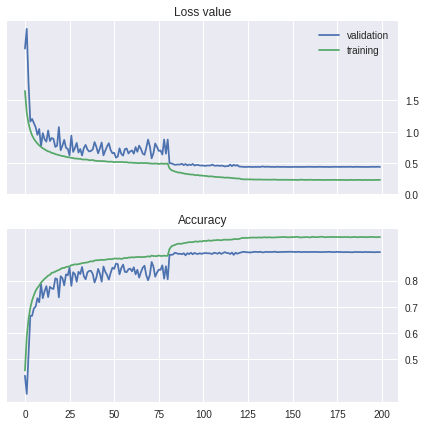

In [12]:
records     = pd.read_csv(folderpath+modelname +'.csv')
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'], label="validation")
plt.plot(records['loss'],label="training")
plt.yticks([0.00,0.50,1.00,1.50])
plt.title('Loss value',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])

plt.subplot(212)
plt.plot(records['val_accuracy'],label="validation")
plt.plot(records['accuracy'],label="training")
plt.yticks([0.5,0.6,0.7,0.8])
plt.title('Accuracy',fontsize=12)
ax.legend()
plt.show()

## **13. Save the model plot**
---

In [13]:
plotpath  = folderpath+modelname+'_plot.png'
plot_model(model, 
           to_file=plotpath, 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')

print("Path to plot:", plotpath)

Path to plot: /content/gdrive/My Drive/iss/prumls/colab/cifar10ResV1Cfg5_plot.png
